# Age Estimation and Gender Classification

In this Notebook, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data.

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.


## Setting Up: Mount the google drive
Mount your google drive to the notebook.

Also don't forget to **enable GPU** before your training.


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

  0%|          | 0/5000 [00:00<?, ?it/s]

                                               image  gender  age
0  /content/drive/MyDrive/train_val/40_0_3_201701...       0   40
1  /content/drive/MyDrive/train_val/75_0_0_201701...       0   75
2  /content/drive/MyDrive/train_val/18_1_0_201701...       1   18
3  /content/drive/MyDrive/train_val/70_1_3_201701...       1   70
4  /content/drive/MyDrive/train_val/26_1_1_201701...       1   26
5  /content/drive/MyDrive/train_val/23_0_1_201701...       0   23
6  /content/drive/MyDrive/train_val/4_0_0_2017010...       0    4
7  /content/drive/MyDrive/train_val/1_1_4_2016122...       1    1
8  /content/drive/MyDrive/train_val/28_0_2_201701...       0   28
9  /content/drive/MyDrive/train_val/72_1_0_201701...       1   72


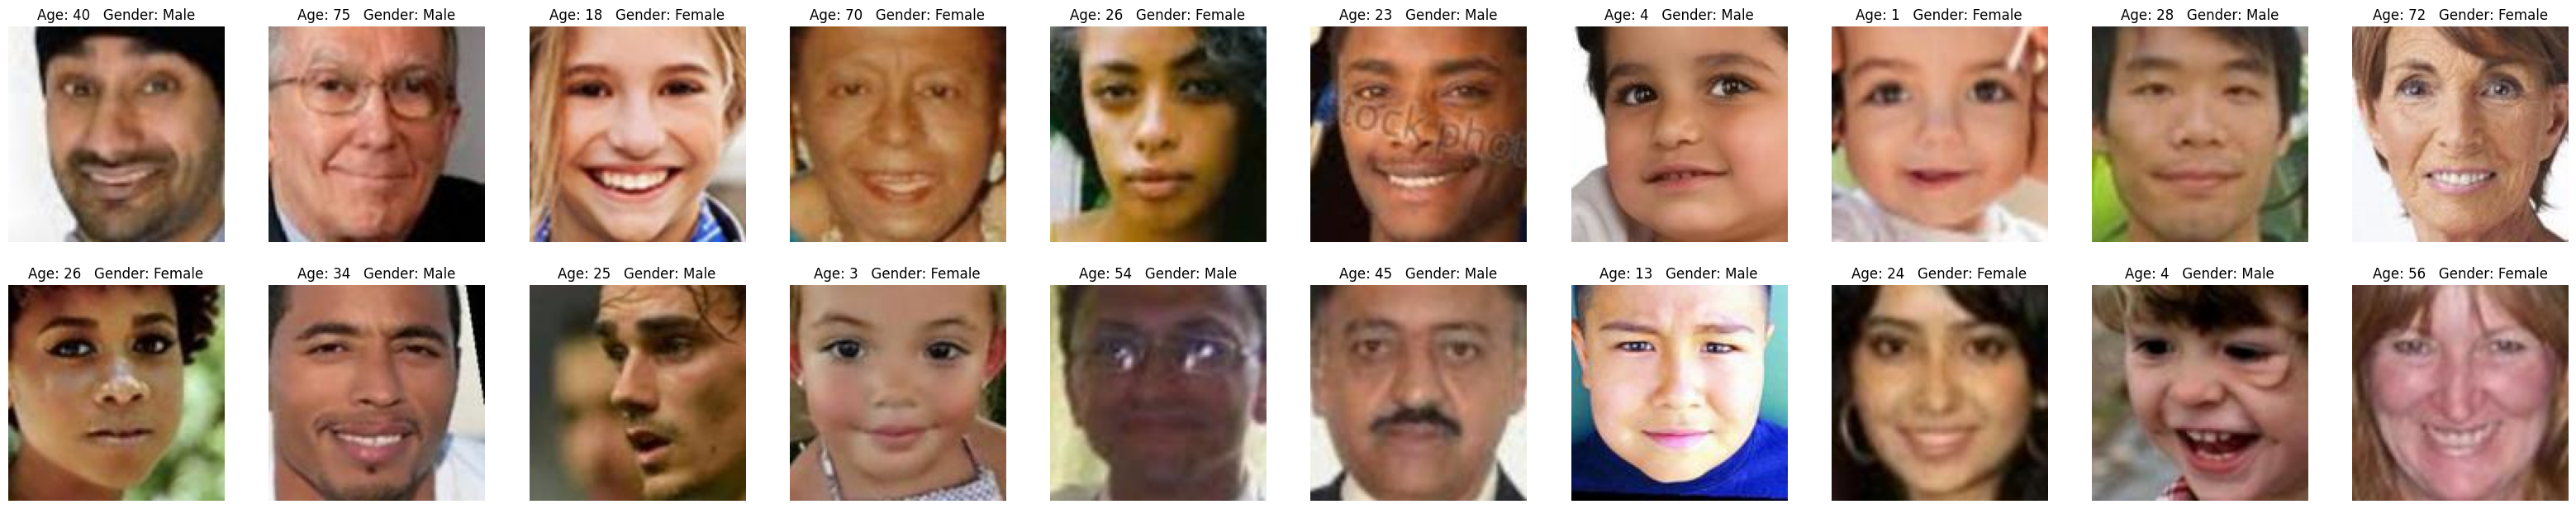

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
%matplotlib inline
from PIL import Image

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
BASE_DIR = '/content/drive/MyDrive/train_val'

image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)


df = pd.DataFrame()
df["image"],df["gender"],df["age"]=image_paths,gender_labels,age_labels
print(df.head(10))

fig = plt.figure(figsize=(40, 40))
rows,columns=10,10
for index in range(20):
  fig.add_subplot(rows, columns, index+1)
  image=Image.open(df.iloc[index]["image"])
  gender="Male" if df.iloc[index]["gender"] == 0 else "Female"
  plt.axis('off')
  plt.title("Age: "+str(df.iloc[index]["age"])+"   Gender: "+ gender)
  plt.imshow(image)

## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [ ]:
from sklearn.model_selection import train_test_split

x=df["image"]
y=df[["gender","age"]]

x_train, x_validate, y_train,y_validate = train_test_split(x,y,random_state=104,train_size=0.8, shuffle=True)

df_train = pd.DataFrame(columns=['image_names','gender',"age"])
df_train['image_names'] = x_train
df_train[['gender','age']] = y_train



df_valid = pd.DataFrame(columns=['image_names','gender',"age"])
df_valid['image_names'] = x_validate
df_valid[['gender','age']] = y_validate


df_train.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)

print(df_train.head())
print(df_valid.head())

                                         image_names  gender  age
0  /content/drive/MyDrive/Colab Notebooks/train_v...       0   70
1  /content/drive/MyDrive/Colab Notebooks/train_v...       0   44
2  /content/drive/MyDrive/Colab Notebooks/train_v...       1   37
3  /content/drive/MyDrive/Colab Notebooks/train_v...       0    9
4  /content/drive/MyDrive/Colab Notebooks/train_v...       0   68
                                         image_names  gender  age
0  /content/drive/MyDrive/Colab Notebooks/train_v...       1   24
1  /content/drive/MyDrive/Colab Notebooks/train_v...       1   50
2  /content/drive/MyDrive/Colab Notebooks/train_v...       0   39
3  /content/drive/MyDrive/Colab Notebooks/train_v...       0   68
4  /content/drive/MyDrive/Colab Notebooks/train_v...       1   46


## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way.
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

img_width, img_height = 128, 128

train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   horizontal_flip = True,
                                   rotation_range = 10,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   brightness_range=[0.2,1.0],
                                   zoom_range=[0.5,1.0])
validate_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_dataframe(dataframe=df_train,directory=BASE_DIR,x_col="image_names",y_col=["gender", "age"],target_size=(img_width, img_height),batch_size=32,class_mode="multi_output",shuffle=True,seed=42)

validation_generator = validate_datagen.flow_from_dataframe(dataframe=df_valid,directory=BASE_DIR,x_col="image_names",y_col=["gender", "age"],target_size=(img_width, img_height),batch_size=32,class_mode="multi_output",shuffle=False)



Found 4000 validated image filenames.
Found 1000 validated image filenames.


## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting.
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting.

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 32)         896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 61, 61, 64)           18496     ['max_pooling2d[0][0]']   

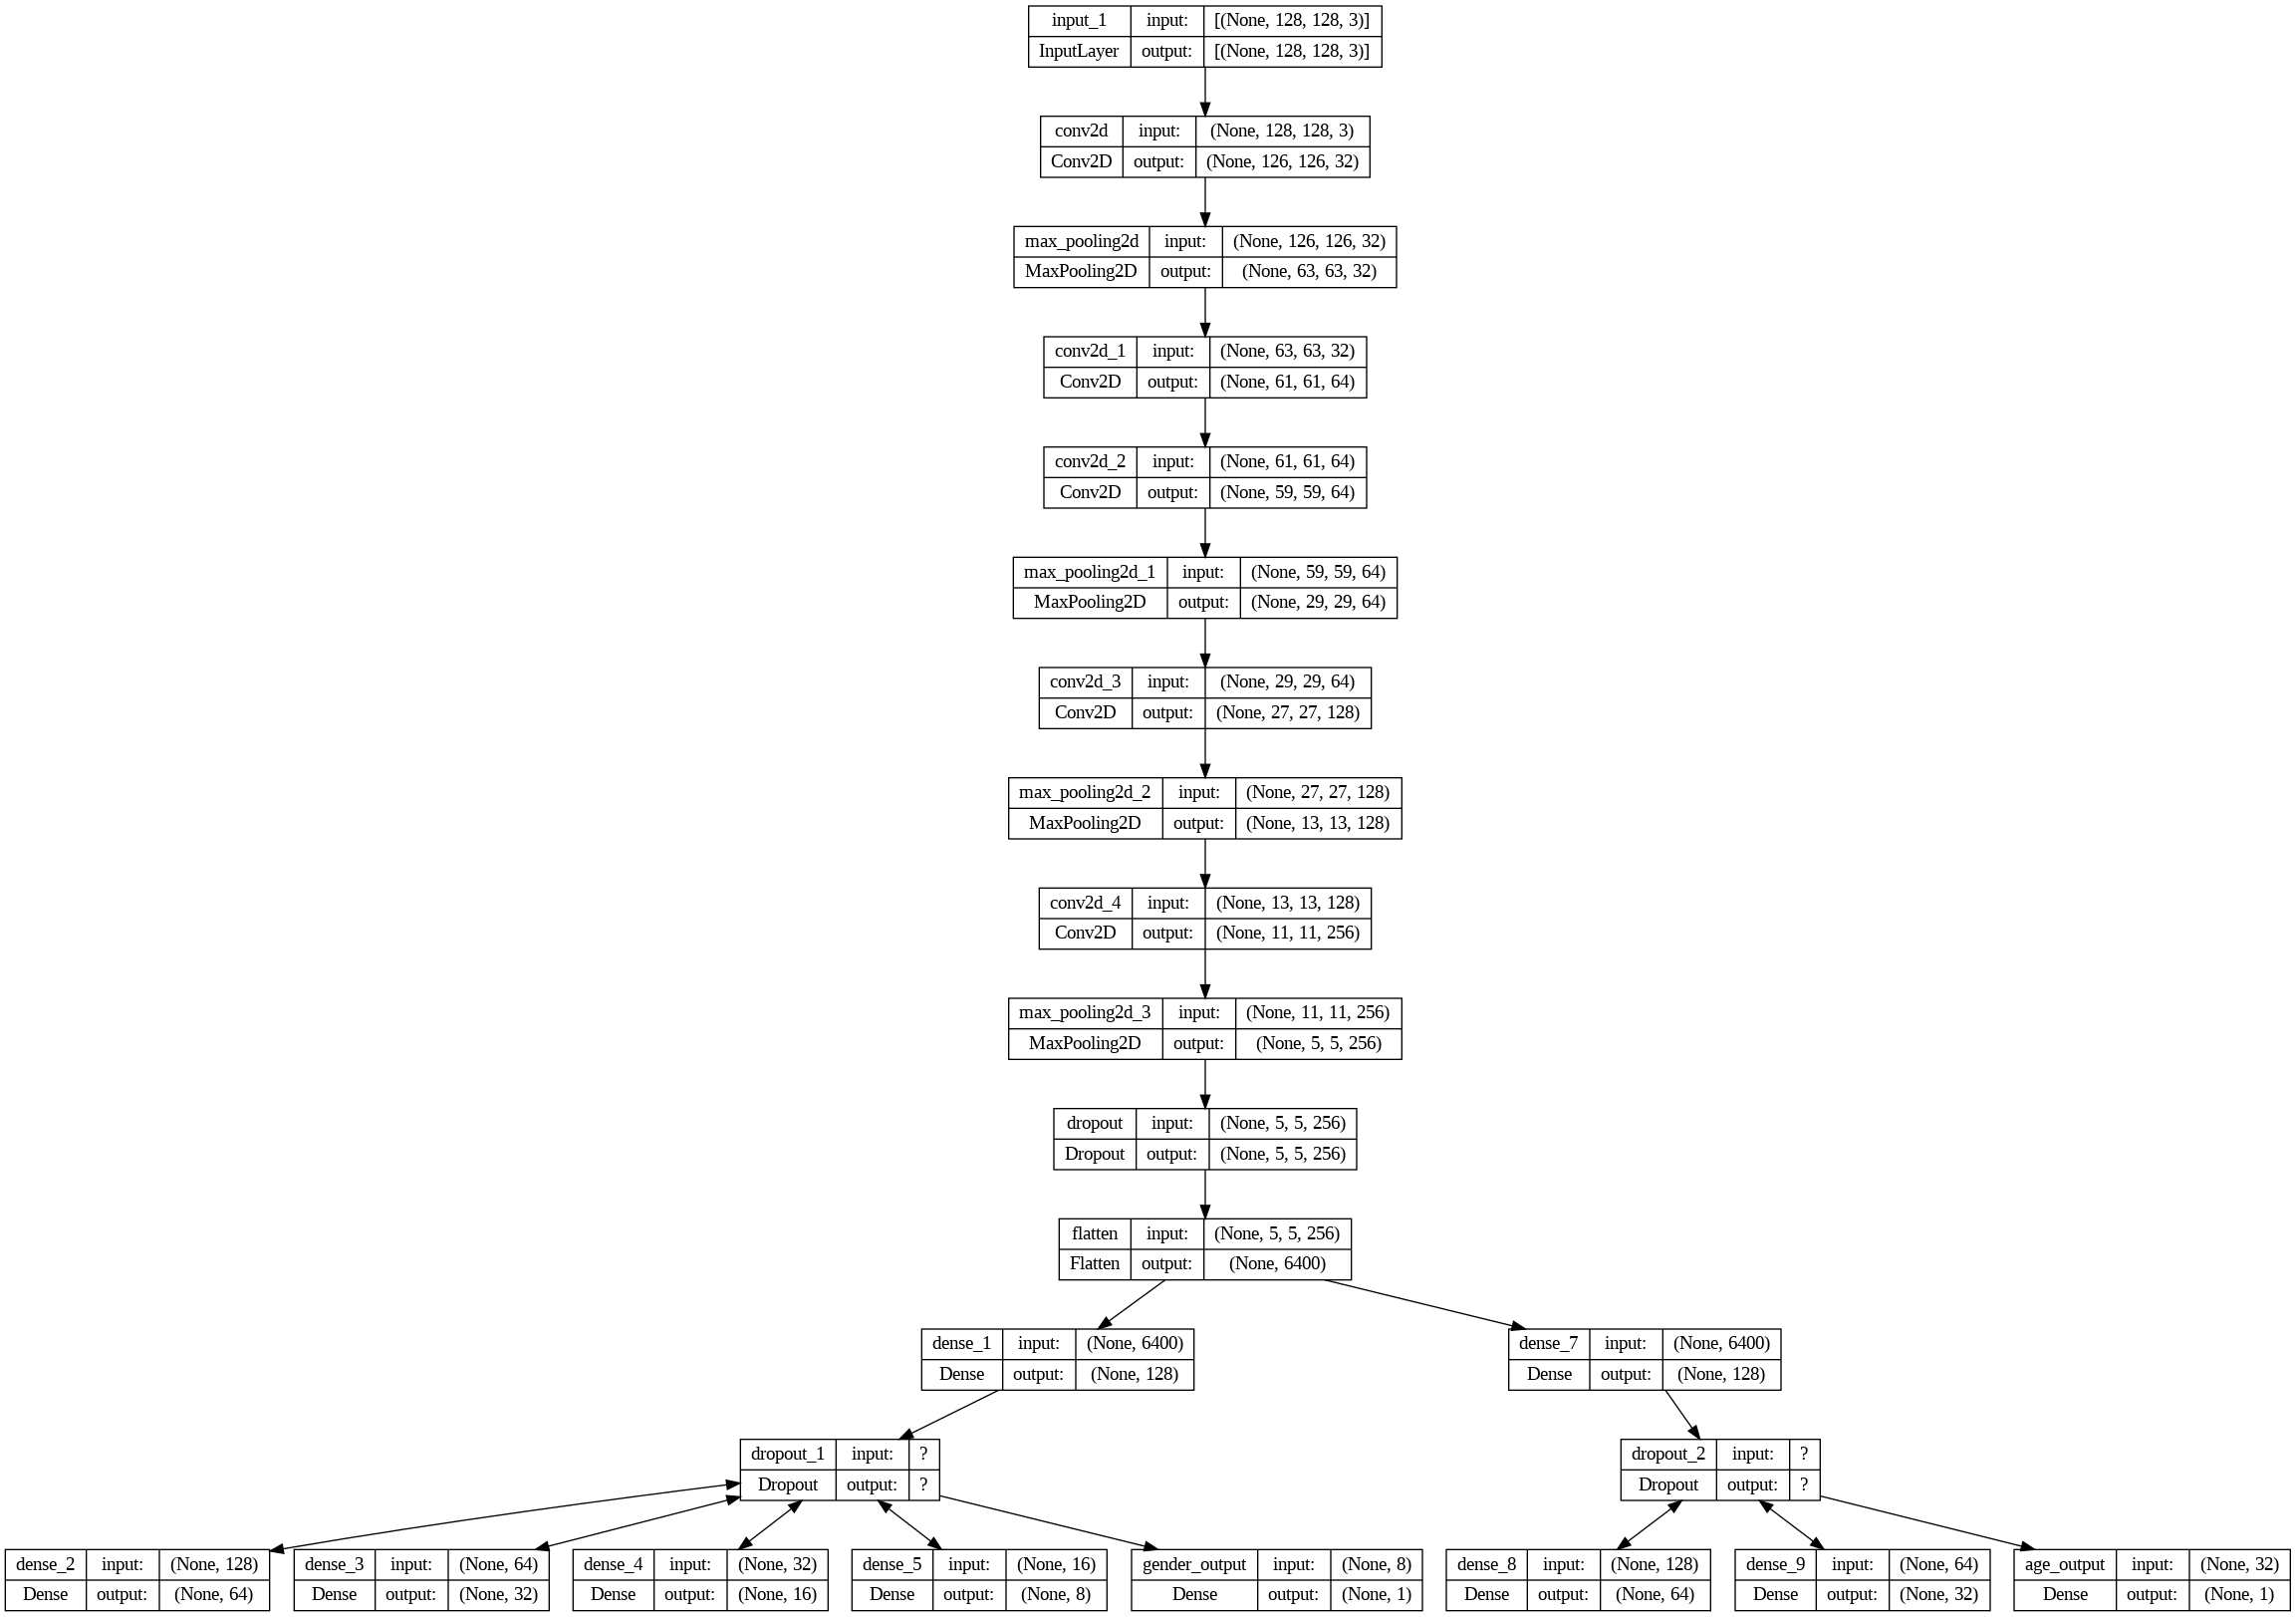

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D,BatchNormalization,Flatten, Dense
from tensorflow.keras.models import Sequential
from keras.regularizers import L1, L2

def create_age_gender_model():

  inputs = Input(shape=(128,128,3))
  conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(pool1)
  conv6 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv6)
  conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(256, kernel_size=(3, 3),activation='relu')(pool3)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
  x = Dropout(0.25)(pool4)
  flat = Flatten()(x)

  dropout = Dropout(0.5)
  gender_model = Dense(256, activation='relu')(flat)
  gender_model = dropout(gender_model)
  gender_model = Dense(128, activation='relu')(flat)
  gender_model = dropout(gender_model)
  gender_model = Dense(64, activation='relu')(gender_model)
  gender_model = dropout(gender_model)
  gender_model = Dense(32, activation='relu')(gender_model)
  gender_model = dropout(gender_model)
  gender_model = Dense(16, activation='relu')(gender_model)
  gender_model = dropout(gender_model)
  gender_model = Dense(8, activation='relu')(gender_model)
  gender_model = dropout(gender_model)
  gender_model = Dense(1, activation='sigmoid',name='gender_output')(gender_model)

  dropout = Dropout(0.5)
  age_model = Dense(256, activation='relu')(flat)
  age_model = dropout(age_model)
  age_model = Dense(128, activation='relu')(flat)
  age_model = dropout(age_model)
  age_model = Dense(64, activation='relu')(age_model)
  age_model = dropout(age_model)
  age_model = Dense(32, activation='relu')(age_model)
  age_model = dropout(age_model)
  age_model = Dense(1, activation='relu',name='age_output')(age_model)

  # Combine branches (model has two outputs)
  model = Model(inputs=inputs, outputs=[gender_model, age_model])
  return model

modelA = create_age_gender_model()

modelA.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelA, show_shapes=True)

## STEP3A: Compile and train your model
Compile and train your model here.


In [ ]:
your_model_folder=BASE_DIR
batch_size=32
modelA.compile(loss={'gender_output': 'binary_crossentropy', 'age_output': 'mse'},
              optimizer='adam',
              metrics={'gender_output': 'accuracy', 'age_output': 'mae'})

history = modelA.fit(
    train_generator,
    steps_per_epoch=len(df_train) // batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(df_valid) // batch_size
)
modelA.save("/content/drive/MyDrive/age_gender_A.h5")

Epoch 1/50


KeyboardInterrupt: 

## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


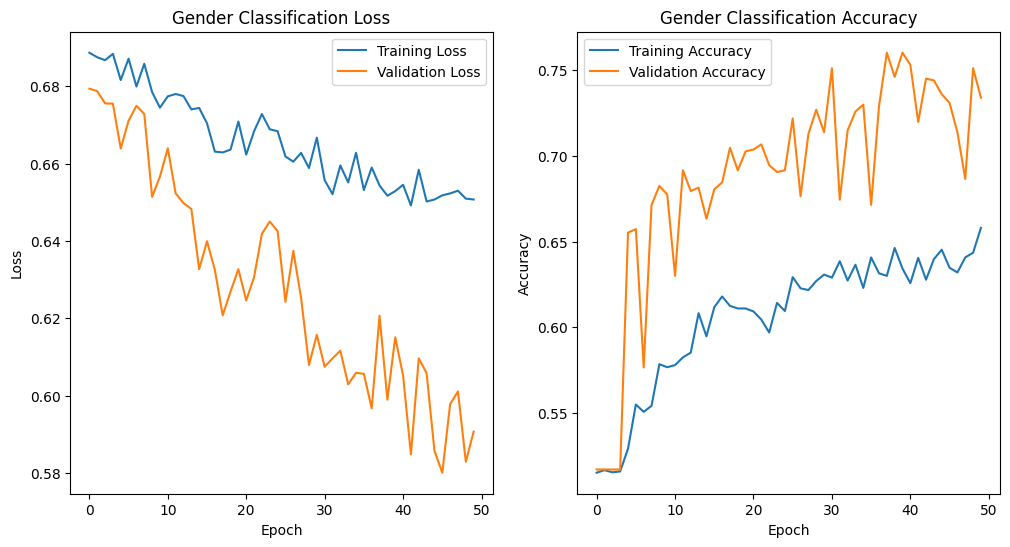

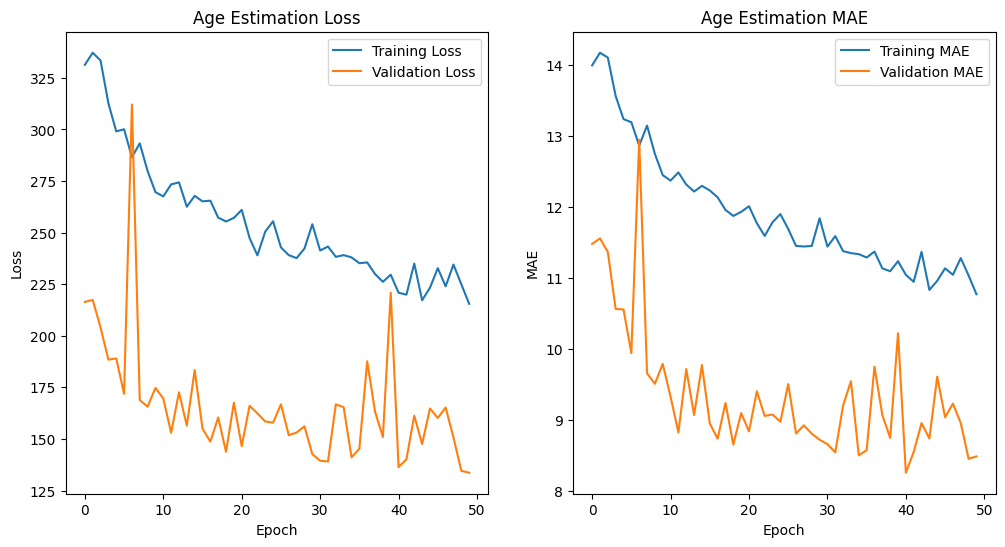

In [ ]:
#
# Add your code here
#
# Plotting training and validation loss for gender classification
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['gender_output_loss'], label='Training Loss')
plt.plot(history.history['val_gender_output_loss'], label='Validation Loss')
plt.title('Gender Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy for gender classification
plt.subplot(1, 2, 2)
plt.plot(history.history['gender_output_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_gender_output_accuracy'], label='Validation Accuracy')
plt.title('Gender Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss for age estimation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['age_output_loss'], label='Training Loss')
plt.plot(history.history['val_age_output_loss'], label='Validation Loss')
plt.title('Age Estimation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation MAE for age estimation
plt.subplot(1, 2, 2)
plt.plot(history.history['age_output_mae'], label='Training MAE')
plt.plot(history.history['val_age_output_mae'], label='Validation MAE')
plt.title('Age Estimation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()


## STEP2B: Build a CNN network based on a pre-trained model
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

58889256/58889256 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 128, 128, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 128, 128, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)           0         ['block1_conv2[0][0]']        
                           

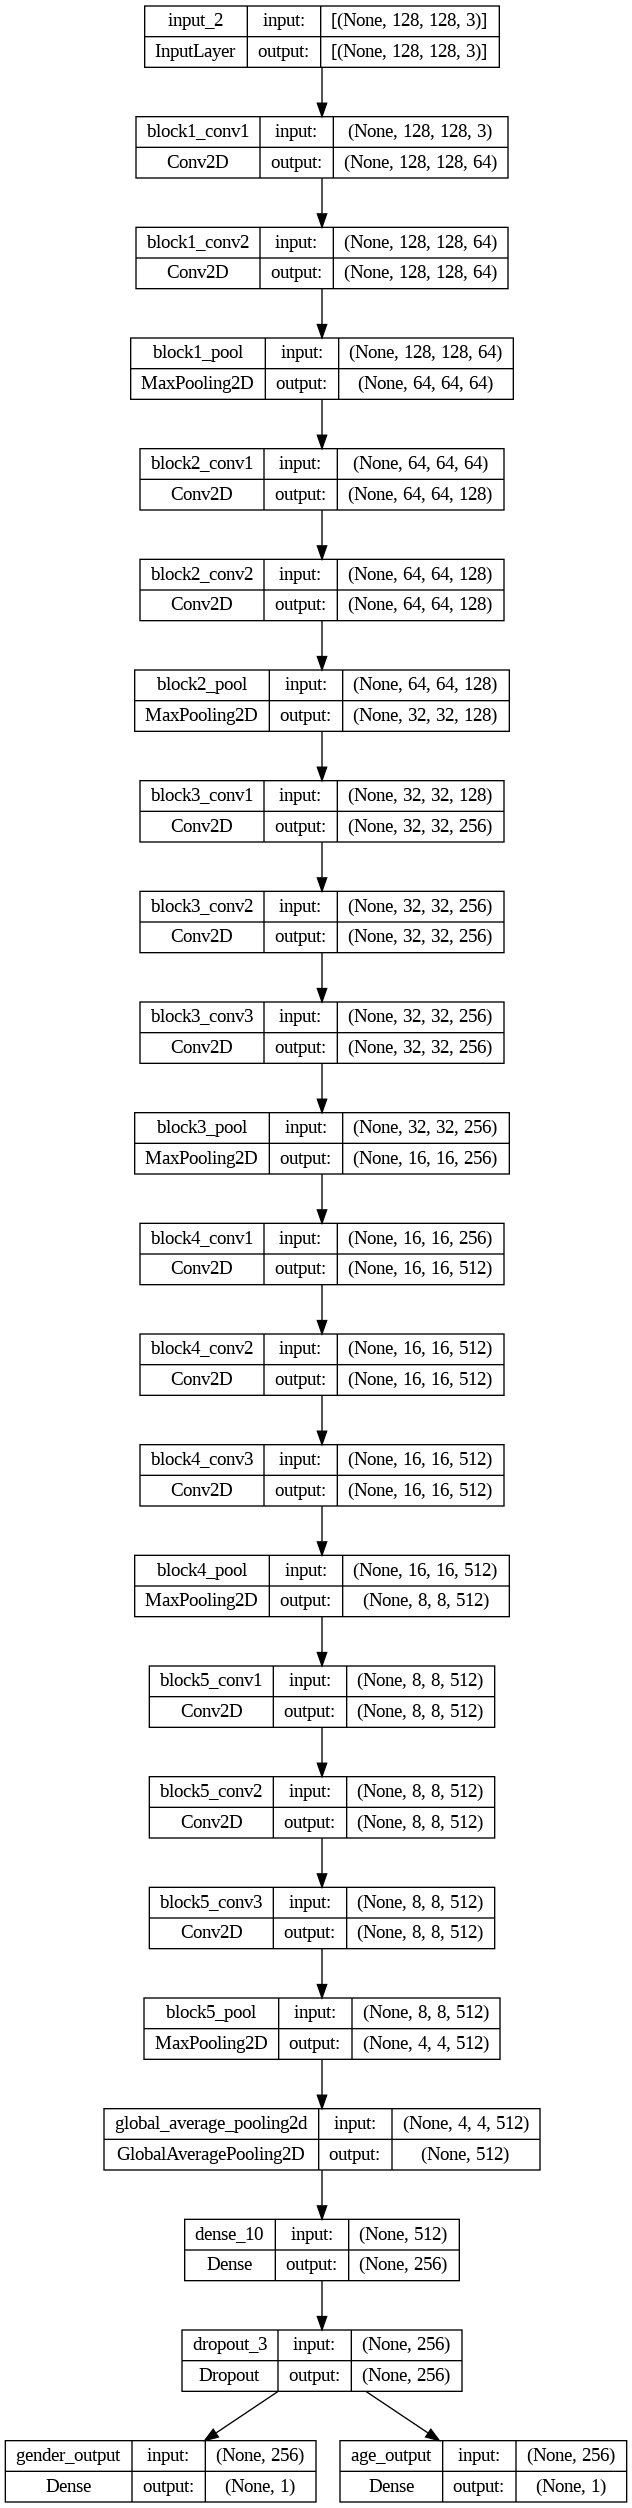

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for gender and age prediction
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Gender prediction output
gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)

# Age prediction output
age_output = Dense(1, activation='relu', name='age_output')(x)

# Combine both outputs into a single model
modelB = Model(inputs=base_model.input, outputs=[gender_output, age_output])

# Summary of the model architecture
modelB.summary()

# Visualize the model architecture
from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True)

## STEP3B: Compile and train your model
Compile and train your model here.



In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the model with appropriate loss functions, metrics, and optimizer
modelB.compile(optimizer=Adam(),
               loss={'gender_output': 'binary_crossentropy', 'age_output': 'mse'},
               metrics={'gender_output': 'accuracy', 'age_output': 'mae'})

# Train the model using the training generator and validation data
history = modelB.fit(train_generator,
                     steps_per_epoch=len(train_generator),
                     epochs=50,
                     validation_data=validation_generator,
                     validation_steps=len(validation_generator))

# Save the trained model
your_model_folder= "/content/drive/MyDrive/Colab Notebooks/train_val"
modelB.save(your_model_folder + "age_gender_B.h5")



Epoch 1/50
125/125 [==============================] - 44s 326ms/step - loss: 265.1912 - gender_output_loss: 0.6765 - age_output_loss: 264.5146 - gender_output_accuracy: 0.5782 - age_output_mae: 12.4010 - val_loss: 201.8401 - val_gender_output_loss: 0.6894 - val_age_output_loss: 201.1507 - val_gender_output_accuracy: 0.5220 - val_age_output_mae: 10.9173
Epoch 2/50
125/125 [==============================] - 40s 320ms/step - loss: 263.8745 - gender_output_loss: 0.6719 - age_output_loss: 263.2026 - gender_output_accuracy: 0.5880 - age_output_mae: 12.4539 - val_loss: 197.3261 - val_gender_output_loss: 0.6842 - val_age_output_loss: 196.6419 - val_gender_output_accuracy: 0.5370 - val_age_output_mae: 10.8144
Epoch 3/50
125/125 [==============================] - 41s 328ms/step - loss: 261.2063 - gender_output_loss: 0.6732 - age_output_loss: 260.5331 - gender_output_accuracy: 0.5962 - age_output_mae: 12.4580 - val_loss: 197.5050 - val_gender_output_loss: 0.6733 - val_age_output_loss: 196.8317 - 

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

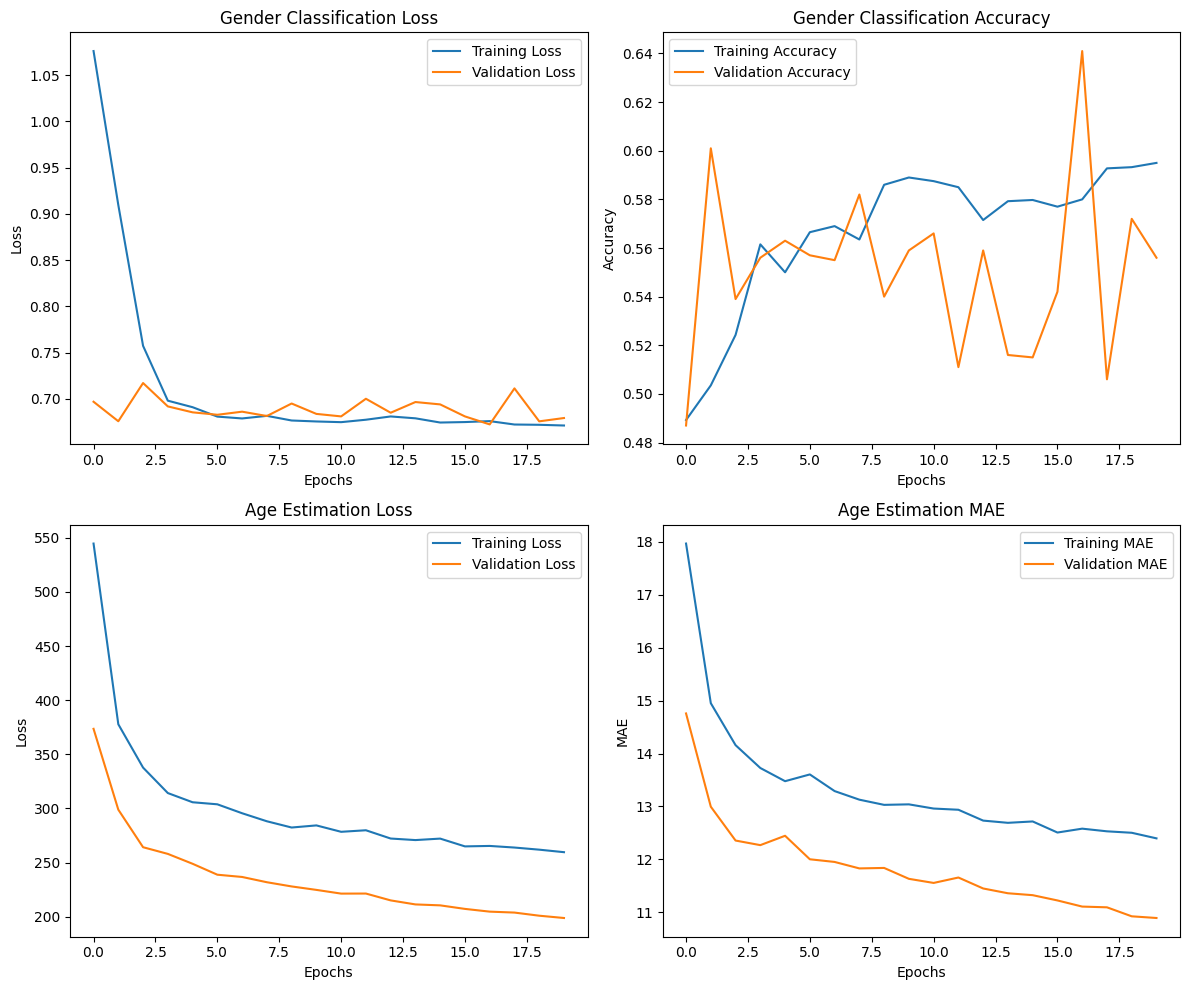

In [ ]:
import matplotlib.pyplot as plt

# Get the training and validation loss for gender classification
gender_loss = history.history['gender_output_loss']
val_gender_loss = history.history['val_gender_output_loss']

# Get the training and validation accuracy for gender classification
gender_accuracy = history.history['gender_output_accuracy']
val_gender_accuracy = history.history['val_gender_output_accuracy']

# Get the training and validation loss for age estimation
age_loss = history.history['age_output_loss']
val_age_loss = history.history['val_age_output_loss']

# Get the training and validation MAE for age estimation
age_mae = history.history['age_output_mae']
val_age_mae = history.history['val_age_output_mae']

# Create subplots for each curve
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot gender classification loss
axs[0, 0].plot(gender_loss, label='Training Loss')
axs[0, 0].plot(val_gender_loss, label='Validation Loss')
axs[0, 0].set_title('Gender Classification Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

# Plot gender classification accuracy
axs[0, 1].plot(gender_accuracy, label='Training Accuracy')
axs[0, 1].plot(val_gender_accuracy, label='Validation Accuracy')
axs[0, 1].set_title('Gender Classification Accuracy')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()

# Plot age estimation loss
axs[1, 0].plot(age_loss, label='Training Loss')
axs[1, 0].plot(val_age_loss, label='Validation Loss')
axs[1, 0].set_title('Age Estimation Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()

# Plot age estimation MAE
axs[1, 1].plot(age_mae, label='Training MAE')
axs[1, 1].plot(val_age_mae, label='Validation MAE')
axs[1, 1].set_title('Age Estimation MAE')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()
